<a href="https://colab.research.google.com/github/angeellogabriel/Artigo_ENIAC_VazaoAfluente/blob/main/TreinaModelos_VazaoAfluente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot -q

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Conv2D, Flatten, Reshape, MaxPooling2D, TimeDistributed,RepeatVector
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
#from livelossplot import PlotLossesKeras

In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # encontrar o final deste padrão
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # verificar se estamos além do conjunto de dados
        if out_end_ix > len(sequences):
            break
        # reunir as partes de entrada e saída do padrão
        seq_x = sequences[i:end_ix, :-1]  # Entrada: Tucuruí e Estreito
        seq_z = sequences[i:end_ix, -1]   # Entrada: Lajeado
        seq_y = sequences[end_ix-1:out_end_ix, -1]  # Saída: Tucuruí
        X.append(np.column_stack((seq_x, seq_z)))  # Entrada combinada: Tucuruí, Estreito e Lajeado
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2) Carregando os dados

In [ ]:
arquivo = '/content/drive/MyDrive/CBA2024-LSTM-VazãoAfluente/CodigosDados/DadosReservatorios.xlsx'
#arquivo = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/CodigosDados/DadosReservatorios.xlsx'
Dados = pd.read_excel(arquivo)
Dados.head()

,AMOSTRA,DATA,TUCURUÍ,ESTREITO,LAJEADO,PEIXE ANGICAL,SÃO SALVADOR,CANA BRAVA,SERRA DA MESA
0,1,1 de jan de 99,8947,3077,1750,1048,571,486,916
1,2,2 de jan de 99,8374,3094,1700,1079,518,332,623
2,3,3 de jan de 99,9699,3269,1779,1186,424,328,762
3,4,4 de jan de 99,8414,3340,2094,1298,403,352,1010
4,5,5 de jan de 99,8822,3322,2385,1413,394,591,562


In [ ]:
# Carrega dados:
t = Dados['AMOSTRA'].values
d = Dados['DATA'].values
yd = Dados['TUCURUÍ'].values
xd = Dados['ESTREITO'].values
zd = Dados['LAJEADO'].values

# Normaliza dados:
ymax = np.max(yd)
y = yd/ymax
x = xd/ymax
z = zd/ymax

In [ ]:
# Agora vamos iniciar a Estruturação de dados
nso = 7
percIdent = 0.75         # Percentual dos dados de identificação
N = len(y)              # Número total de dados
Ni = int(percIdent * N)   # Quantidade de amostras para identificação
ti = np.arange(0, Ni)    # Índices dos dados de identificação
tv = np.arange(Ni - nso, N - nso)    # Índices dos dados de Validação
Nv = len(tv)

di = d[ti]
dv = d[tv]

yi = y[ti]              # Dados de identificação - Tucurui
yv = y[tv]              # Dados de validação - Tucurui

xi = x[ti]              # Dados de identificação - Estreito
xv = x[tv]              # Dados de validação - Estreito

zi = z[ti]              # Dados de identificação - Lajeado
zv = z[tv]              # Dados de validação - Lajeado

In [ ]:
Ni

6688

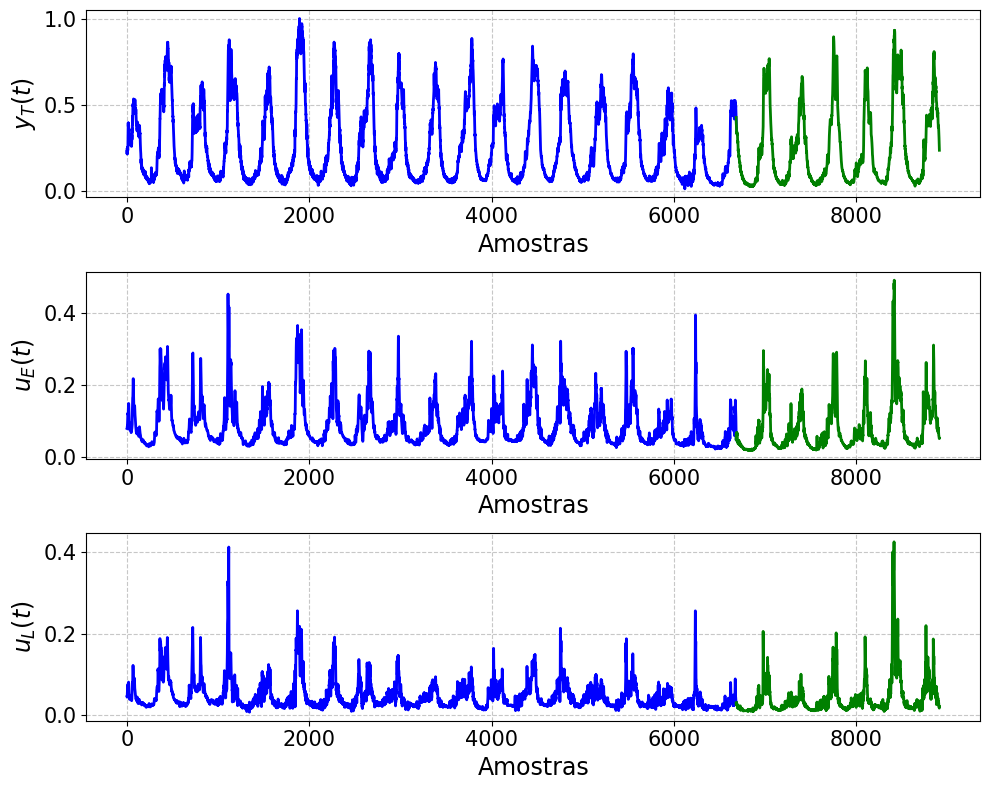

In [ ]:
# Plotando esses gráficos

plt.figure(figsize=(10, 8))

# Gráfico 1 - Tucurui
plt.subplot(311)
plt.plot(ti, yi, color='blue', label='Tucurui', linewidth=2)
plt.plot(tv, yv, color='green', label='Tucurui (Validação)', linewidth=2)
plt.xlabel('Amostras', fontsize=17)
plt.ylabel('$y_T(t)$', fontsize=17)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=15)
# Gráfico 2 - Estreito
plt.subplot(312)
plt.plot(ti, xi, color='blue', label='Estreito', linewidth=2)
plt.plot(tv, xv, color='green', label='Estreito (Validação)', linewidth=2)
plt.xlabel('Amostras', fontsize=17)
plt.ylabel('$u_E(t)$', fontsize=17)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=15)
# Gráfico 3 - Lajeado
plt.subplot(313)
plt.plot(ti, zi, color='blue', label='Lajeado', linewidth=2)
plt.plot(tv, zv, color='green', label='Lajeado (Validação)', linewidth=2)
plt.xlabel('Amostras', fontsize=17)
plt.ylabel('$u_L(t)$', fontsize=17)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.figtext(0.5, 1, 'Identificação 80% x Validação 20%', ha='center', fontsize=13, bbox=dict(facecolor='green', alpha=0))
plt.tight_layout()
plt.show()

In [ ]:
# Organizando os dados de entrada e saída
yii = y[ti + 1].reshape(Ni, 1)
yi = yi.reshape(Ni, 1)
xi = xi.reshape(Ni, 1)
zi = zi.reshape(Ni, 1)

# Criando o dataset combinando as séries temporais
dataset_treino = np.hstack((xi, yi, zi, yii))
nsi = 30
X_treino, y_treino = split_sequences(dataset_treino, nsi, nso)
nf = X_treino.shape[2]

In [ ]:
# Dados de validação
yvv = y[tv + 1].reshape(Nv, 1)
yv = yv.reshape(Nv, 1)
xv = xv.reshape(Nv, 1)
zv = zv.reshape(Nv, 1)

dataset_val = np.hstack((xv, yv, zv, yvv))
X_teste, y_teste = split_sequences(dataset_val, nsi, nso)

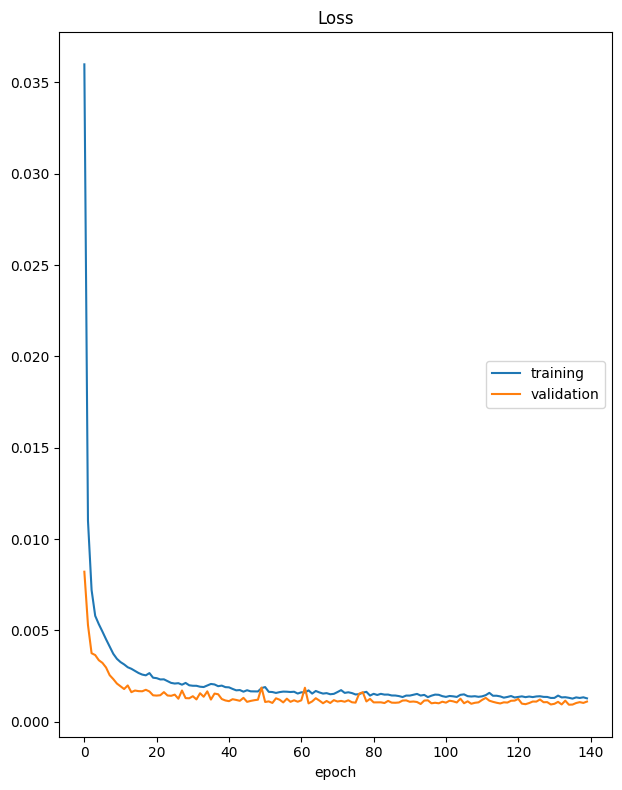

Loss
	training         	 (min:    0.001, max:    0.036, cur:    0.001)
	validation       	 (min:    0.001, max:    0.008, cur:    0.001)
14/14 [==============================] - 6s 437ms/step - loss: 0.0013 - val_loss: 0.0011


In [ ]:
# Modelo LSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(nsi, nf)))
modelLSTM.add(Dropout(0.3))
modelLSTM.add(LSTM(units=100, return_sequences=True))
modelLSTM.add(Dropout(0.3))
modelLSTM.add(LSTM(units=50))
modelLSTM.add(Dropout(0.3))
modelLSTM.add(Dense(nso, activation='linear'))
modelLSTM.compile(optimizer=Adam(learning_rate=0.005), loss='mse')

N_epocas = 140
N_btsize = 500

DadosTreinoLSTM = modelLSTM.fit(X_treino, y_treino,
                            epochs = N_epocas,
                            validation_data=(X_teste, y_teste),
                            batch_size=N_btsize,
                            callbacks=[PlotLossesKeras()],
                            verbose=1)

19:32 minutos sem GPU T4

Text(0, 0.5, 'Custo')

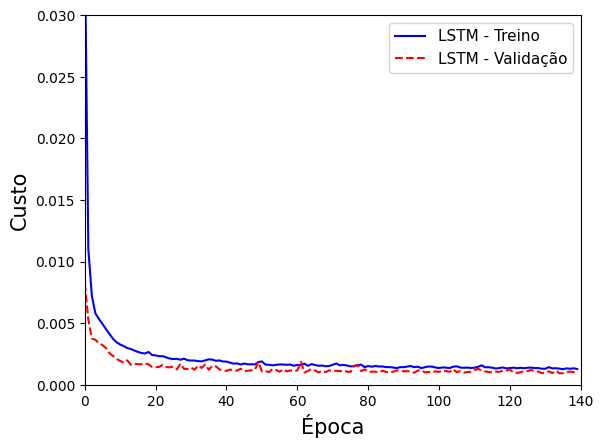

In [ ]:
datatreinoLSTM = {'LSTM_custo_treino'       : DadosTreinoLSTM.history['loss'],
              'LSTM_custo_val'          : DadosTreinoLSTM.history['val_loss']}

# Plotando o logaritmo da perda do modelo LSTM
plt.plot((datatreinoLSTM['LSTM_custo_treino']), label='LSTM - Treino', color='blue')
# Plotando o logaritmo da perda do modelo LSTM
plt.plot((datatreinoLSTM['LSTM_custo_val']),'--', label='LSTM - Validação', color='red')
plt.xlim(0,140)
plt.ylim(0,0.030)
plt.legend(fontsize=11)
plt.xlabel('Época', fontsize=15)
plt.ylabel('Custo', fontsize=15)

In [ ]:
N_epocas = 140
N_btsize = 500

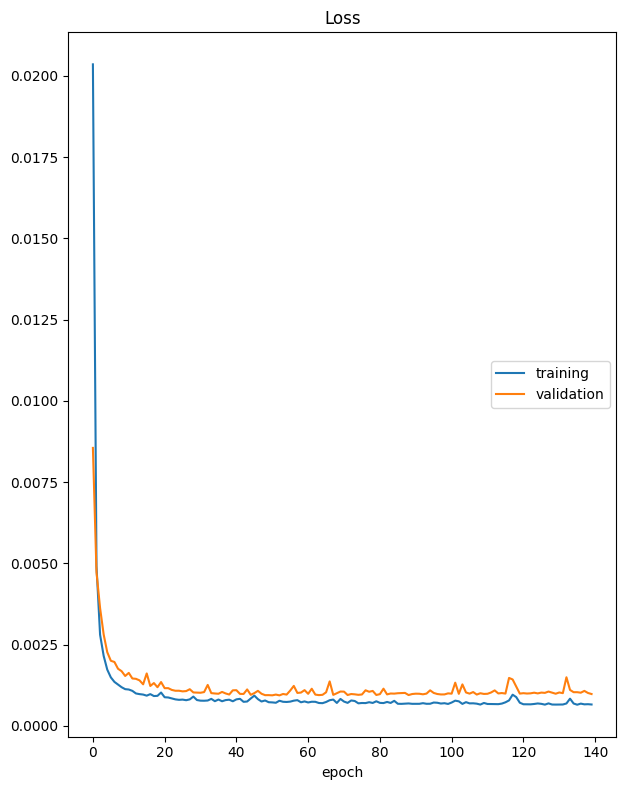

Loss
	training         	 (min:    0.001, max:    0.020, cur:    0.001)
	validation       	 (min:    0.001, max:    0.009, cur:    0.001)
14/14 [==============================] - 1s 47ms/step - loss: 6.5617e-04 - val_loss: 9.7834e-04


In [ ]:
# Modelo CONV1D
modelCNN1D = Sequential()
modelCNN1D.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nsi, nf)))
modelCNN1D.add(MaxPooling1D(pool_size=2))
modelCNN1D.add(Flatten())
modelCNN1D.add(Dense(50, activation='relu'))
modelCNN1D.add(Dense(nso, activation='linear'))
modelCNN1D.compile(optimizer=Adam(learning_rate=0.005), loss='mse')

DadosTreinoCNN1D =  modelCNN1D.fit(X_treino, y_treino,
                            epochs = N_epocas,
                            validation_data=(X_teste, y_teste),
                            batch_size=N_btsize,
                            callbacks=[PlotLossesKeras()],
                            verbose=1)

2:23 SEM GPU T4

Text(0, 0.5, 'Custo')

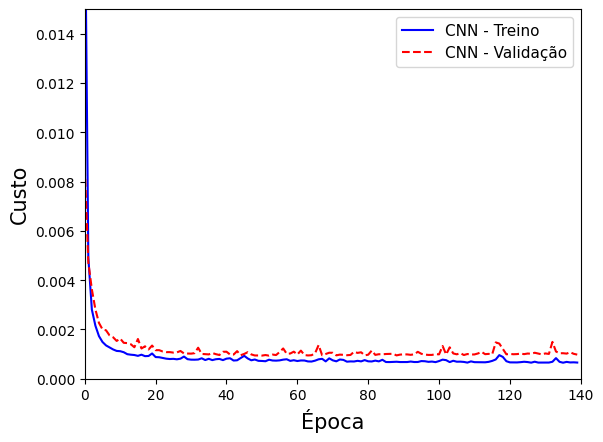

In [ ]:
datatreinoCNN1D = {'CNN1D_custo_treino'       : DadosTreinoCNN1D.history['loss'],
              'CNN1D_custo_val'          : DadosTreinoCNN1D.history['val_loss']}

# Plotando o logaritmo da perda do modelo LSTM
plt.plot((datatreinoCNN1D['CNN1D_custo_treino']), label='CNN - Treino', color='blue')
# Plotando o logaritmo da perda do modelo LSTM
plt.plot((datatreinoCNN1D['CNN1D_custo_val']),'--', label='CNN - Validação', color='red')
plt.xlim(0,140)
plt.ylim(0,0.015)
plt.legend(fontsize=11)
plt.xlabel('Época', fontsize=15)
plt.ylabel('Custo', fontsize=15)

In [ ]:
X_treino.shape

(6653, 30, 4)

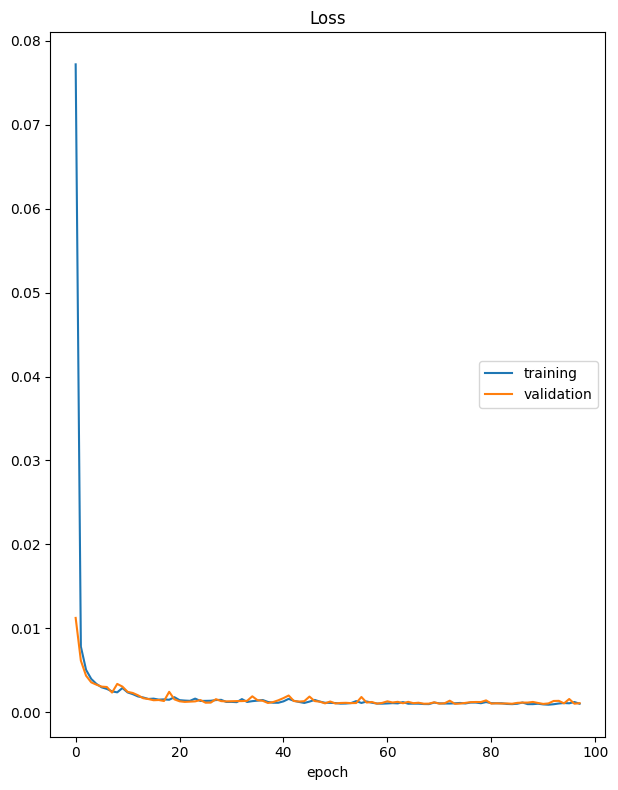

Loss
	training         	 (min:    0.001, max:    0.077, cur:    0.001)
	validation       	 (min:    0.001, max:    0.011, cur:    0.001)
14/14 [==============================] - 24s 2s/step - loss: 0.0010 - val_loss: 0.0011
Epoch 99/140
 6/14 [===========>..................] - ETA: 13s - loss: 9.7927e-04

KeyboardInterrupt: 

In [ ]:
#LSTM-CNN modelo
modelLSTMCNN1D = Sequential()
modelLSTMCNN1D.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nsi, nf)))
modelLSTMCNN1D.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nsi, nf)))
modelLSTMCNN1D.add(MaxPooling1D(pool_size=2))
modelLSTMCNN1D.add(Dropout(0.3))
modelLSTMCNN1D.add(Flatten())
modelLSTMCNN1D.add(RepeatVector(nsi))
modelLSTMCNN1D.add(LSTM(units=100))
modelLSTMCNN1D.add(Dense(nso, activation='linear'))
modelLSTMCNN1D.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
DadosTreinoLSTMCNN1D =  modelLSTMCNN1D.fit(X_treino, y_treino,
                            epochs = N_epocas,
                            validation_data=(X_teste, y_teste),
                            batch_size=N_btsize,
                            callbacks=[PlotLossesKeras()],
                            verbose=1)

#teste 55:56

03:28 SEM GPU T4

Text(0, 0.5, 'Custo')

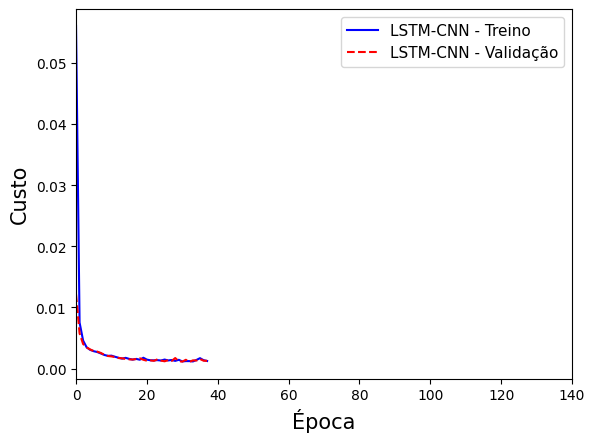

In [ ]:
datatreinoLSTMCNN1D = {'LSTMCNN1D_custo_treino'       : DadosTreinoLSTMCNN1D.history['loss'],
              'LSTMCNN1D_custo_val'          : DadosTreinoLSTMCNN1D.history['val_loss']}

# Plotando o logaritmo da perda do modelo LSTM
plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_treino']), label='LSTM-CNN - Treino', color='blue')
# Plotando o logaritmo da perda do modelo LSTM
plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_val']),'--', label='LSTM-CNN - Validação', color='red')
plt.xlim(0,140)
plt.legend(fontsize=11)
plt.xlabel('Época', fontsize=15)
plt.ylabel('Custo', fontsize=15)

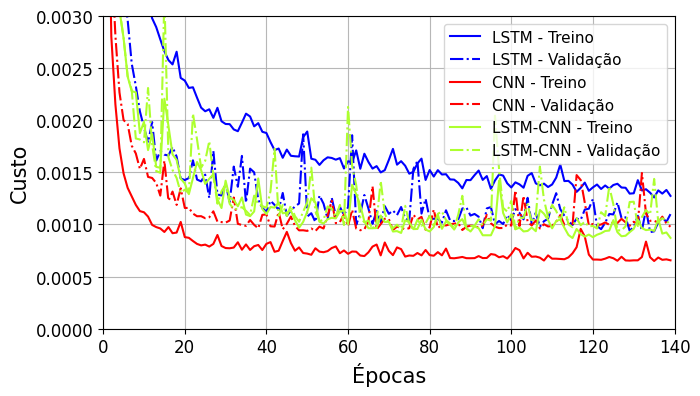

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot((datatreinoLSTM['LSTM_custo_treino']), label='LSTM - Treino', color='blue')

plt.plot((datatreinoLSTM['LSTM_custo_val']),'-.', label='LSTM - Validação', color='blue')
plt.plot((datatreinoCNN1D['CNN1D_custo_treino']), label='CNN - Treino', color='red')

plt.plot((datatreinoCNN1D['CNN1D_custo_val']),'-.', label='CNN - Validação', color='red')

plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_treino']), label='LSTM-CNN - Treino', color='greenyellow')

plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_val']),'-.', label='LSTM-CNN - Validação', color='greenyellow')
# Definindo o limite máximo de épocas para 400
limite_epocas = 140#N_epocas
plt.xlim(0, limite_epocas)
plt.ylim(0,0.015)

# Adicionando legenda e rótulos

plt.xlabel('Épocas', fontsize=15)
plt.ylabel('Custo', fontsize=15)
plt.legend(fontsize=11)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, alpha=0.9)
plt.tight_layout()
plt.ylim(0,0.003)
plt.show()

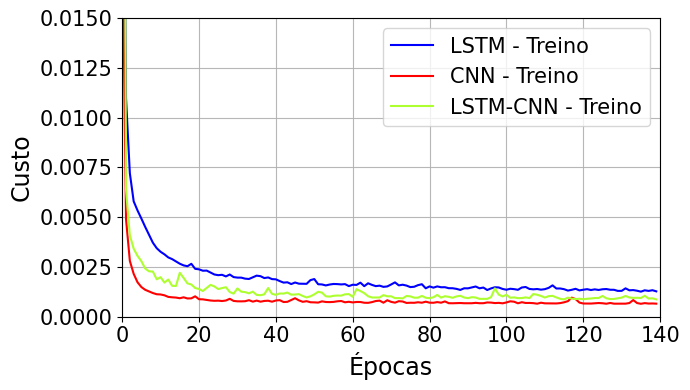

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot((datatreinoLSTM['LSTM_custo_treino']), label='LSTM - Treino', color='blue')

#plt.plot((datatreinoLSTM['LSTM_custo_val']),'-.', label='LSTM - Validação', color='blue')
plt.plot((datatreinoCNN1D['CNN1D_custo_treino']), label='CNN - Treino', color='red')

#plt.plot((datatreinoCNN1D['CNN1D_custo_val']),'-.', label='CNN - Validação', color='red')


plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_treino']), label='LSTM-CNN - Treino', color='greenyellow')

#plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_val']),'-.', label='LSTM-CNN - Validação', color='greenyellow')
# Definindo o limite máximo de épocas para 400
limite_epocas = 140#N_epocas
plt.xlim(0, limite_epocas)
plt.ylim(0,0.015)

# Adicionando legenda e rótulos

plt.xlabel('Épocas', fontsize=17)
plt.ylabel('Custo', fontsize=17)
plt.legend(fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.grid(True, alpha=0.9)
plt.tight_layout()
plt.show()

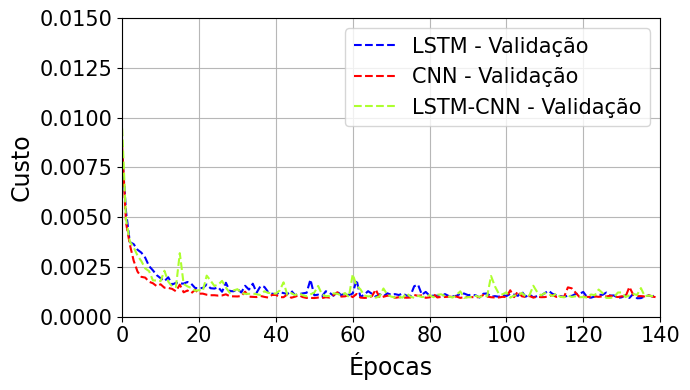

In [ ]:
plt.figure(figsize=(7, 4))

#plt.plot((datatreinoLSTM['LSTM_custo_treino']), label='LSTM - Treino', color='blue')

plt.plot((datatreinoLSTM['LSTM_custo_val']),'--', label='LSTM - Validação', color='blue')
#plt.plot((datatreinoCNN1D['CNN1D_custo_treino']), label='CNN - Treino', color='red')

plt.plot((datatreinoCNN1D['CNN1D_custo_val']),'--', label='CNN - Validação', color='red')

#plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_treino']), label='LSTM-CNN - Treino', color='greenyellow')

plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_val']),'--', label='LSTM-CNN - Validação', color='greenyellow')
# Definindo o limite máximo de épocas para 400
limite_epocas = 140#N_epocas
plt.xlim(0, limite_epocas)
plt.ylim(0,0.015)

plt.xlabel('Épocas', fontsize=17)
plt.ylabel('Custo', fontsize=17)
plt.legend(fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.grid(True, alpha=0.9)
plt.tight_layout()
plt.show()

In [ ]:
#pasta_modelos = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/Modelos Novos'
pasta_modelos = '/content/drive/MyDrive/CBA2024-LSTM-VazãoAfluente/Modelos Novos'
caminhoLSTM = pasta_modelos + '/modelLSTM.keras'
caminhoCNN1D = pasta_modelos + '/modelCNN1D.keras'
caminhoLSTMCNN1D = pasta_modelos + '/modelLSTMCNN1D.keras'


In [ ]:
modelo_lstm = load_model(caminhoLSTM)

modelo_cnn1d = load_model(caminhoCNN1D)

modelo_lstm_cnn1d = load_model(caminhoLSTMCNN1D)

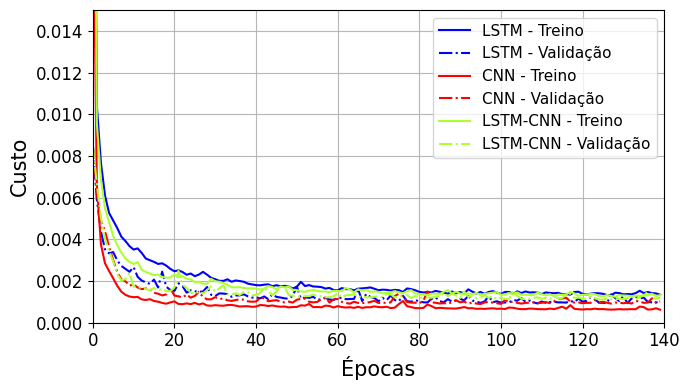

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot((datatreinoLSTM['LSTM_custo_treino']), label='LSTM - Treino', color='blue')

plt.plot((datatreinoLSTM['LSTM_custo_val']),'-.', label='LSTM - Validação', color='blue')
plt.plot((datatreinoCNN1D['CNN1D_custo_treino']), label='CNN - Treino', color='red')

plt.plot((datatreinoCNN1D['CNN1D_custo_val']),'-.', label='CNN - Validação', color='red')

plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_treino']), label='LSTM-CNN - Treino', color='greenyellow')

plt.plot((datatreinoLSTMCNN1D['LSTMCNN1D_custo_val']),'-.', label='LSTM-CNN - Validação', color='greenyellow')
# Definindo o limite máximo de épocas para 400
limite_epocas = 140#N_epocas
plt.xlim(0, limite_epocas)
plt.ylim(0,0.015)

# Adicionando legenda e rótulos

plt.xlabel('Épocas', fontsize=15)
plt.ylabel('Custo', fontsize=15)
plt.legend(fontsize=11)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, alpha=0.9)
plt.tight_layout()
plt.show()

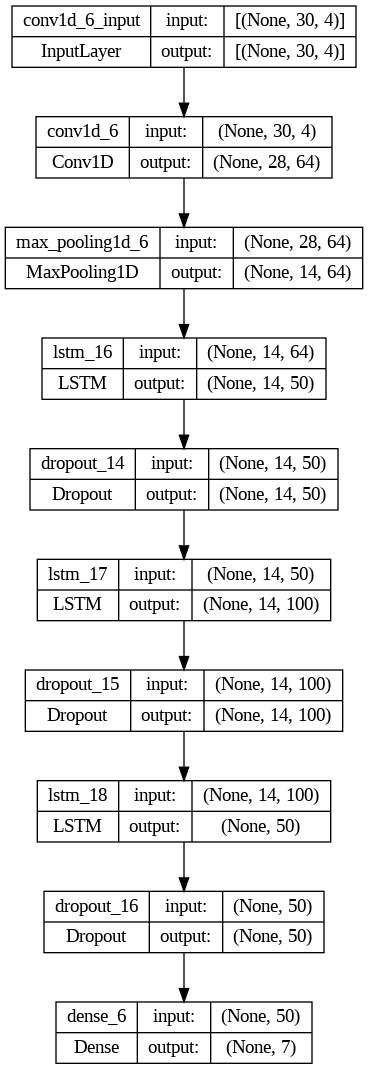

In [ ]:
plot_model(modelo_lstm, to_file='arq_lstm.png', show_shapes=True, show_layer_names=True)
plot_model(modelo_cnn1d, to_file='arq_cnn.png', show_shapes=True, show_layer_names=True)
plot_model(modelo_lstm_cnn1d, to_file='arq_lstm-cnn.png', show_shapes=True, show_layer_names=True)

# Calculando as metricas


In [ ]:
yp_LSTM = modelo_lstm.predict(X_teste)
yp_CNN1D = modelo_cnn1d.predict(X_teste)
#yp_CNN2D = modeloCNN2D.predict(X_teste)
yp_LSTMCNN1D = modelo_lstm_cnn1d.predict(X_teste)
#yp_LSTMCNN2D = modelLSTMCNN2D.predict(X_teste)

69/69 [==============================] - 1s 5ms/step


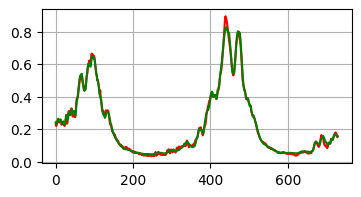

In [ ]:
enderecoSimul = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/Simulacoes/'
plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,0], label='Valor Real',color='red')
plt.plot(yp_LSTM[600:1330,0], label='LSTM - 1º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'LSTM1oDia.png', dpi = 300)
plt.show()

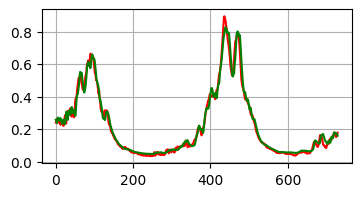

In [ ]:
plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,3], label='Valor Real',color='red')
plt.plot(yp_LSTM[600:1330,3], label='LSTM - 1º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'LSTM4oDia.png', dpi = 300)
plt.show()

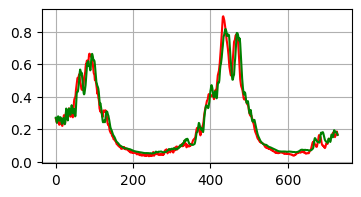

In [ ]:
plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,6], label='Valor Real',color='red')
plt.plot(yp_LSTM[600:1330,6], label='LSTM - 7º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'LSTM7oDia.png', dpi = 300)
plt.show()

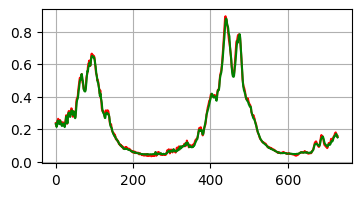

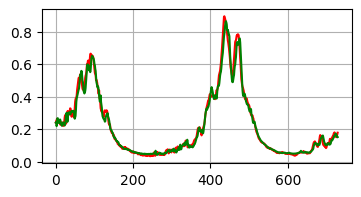

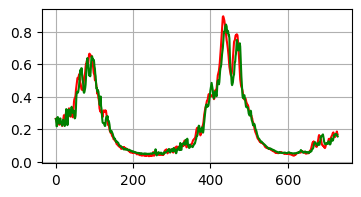

In [ ]:
plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,0], label='Valor Real',color='red')
plt.plot(yp_CNN1D[600:1330,0], label='LSTM - 1º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'CNN1oDia.png', dpi = 300)

plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,3], label='Valor Real',color='red')
plt.plot(yp_CNN1D[600:1330,3], label='LSTM - 4º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'CNN4oDia.png', dpi = 300)

plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,6], label='Valor Real',color='red')
plt.plot(yp_CNN1D[600:1330,6], label='LSTM - 7º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'CNN7oDia.png', dpi = 300)


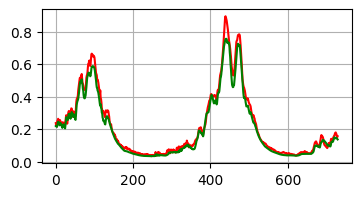

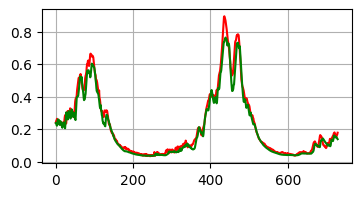

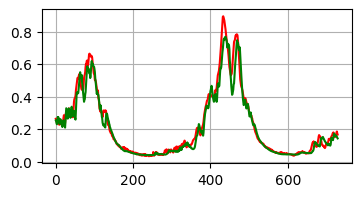

In [ ]:
plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,0], label='Valor Real',color='red')
plt.plot(yp_LSTMCNN1D[600:1330,0], label='CNN+LSTM - 1º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'CNNLSTM1oDia.png', dpi = 300)

plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,3], label='Valor Real',color='red')
plt.plot(yp_LSTMCNN1D[600:1330,3], label='CNN+LSTM - 4º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'CNNLSTM4oDia.png', dpi = 300)

plt.figure(figsize=(4,2))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,6], label='Valor Real',color='red')
plt.plot(yp_LSTMCNN1D[600:1330,6], label='CNN+LSTM - 7º Dia', color='green')
plt.grid()
plt.savefig(enderecoSimul+'CNNLSTM7oDia.png', dpi = 300)

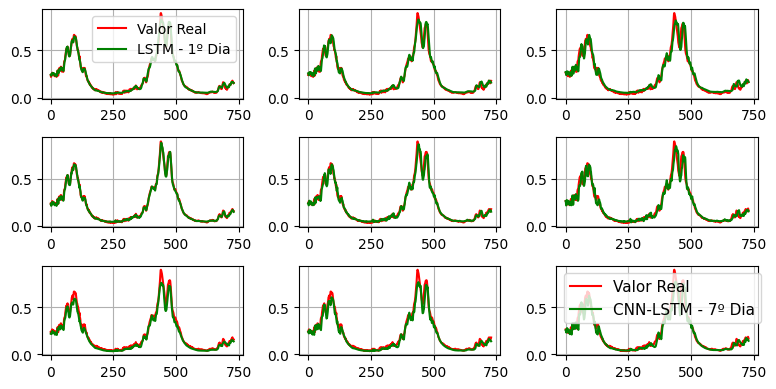

In [ ]:
# Realizando previsões

plt.figure(figsize=(8,4))  # Definindo o tamanho da figura
plt.subplot(3,3,1)
plt.plot(y_teste[600:1330,0], label='Valor Real',color='red')
plt.plot(yp_LSTM[600:1330,0], label='LSTM - 1º Dia', color='green')
plt.legend()
plt.savefig('LSTM1oDia.png')
plt.grid()
plt.subplot(3,3,2)
plt.plot(y_teste[600:1330,3], label='Valor Real',color='red')
plt.plot(yp_LSTM[600:1330,3], label='LSTM - 4º Dia', color='green')
plt.grid()
plt.subplot(3,3,3)
plt.plot(y_teste[600:1330,6], label='Valor Real',color='red')
plt.plot(yp_LSTM[600:1330,6], label='LSTM - 7º Dia', color='green')
plt.grid()

plt.subplot(3,3,4)
plt.plot(y_teste[600:1330,0], label='Valor Real',color='red')
plt.plot(yp_CNN1D[600:1330,0], label='CNN - 1º Dia', color='green')
plt.grid()
plt.subplot(3,3,5)
plt.plot(y_teste[600:1330,3], label='Valor Real',color='red')
plt.plot(yp_CNN1D[600:1330,3], label='CNN - 4º Dia', color='green')
plt.grid()
plt.subplot(3,3,6)
plt.plot(y_teste[600:1330,6], label='Valor Real',color='red')
plt.plot(yp_CNN1D[600:1330,6], label='CNN - 7º Dia', color='green')
plt.grid()
plt.subplot(3,3,7)
plt.plot(y_teste[600:1330,0], label='Valor Real',color='red')
plt.plot(yp_LSTMCNN1D[600:1330,0], label='CNN-LSTM - 1º Dia', color='green')
plt.grid()
plt.subplot(3,3,8)
plt.plot(y_teste[600:1330,3], label='Valor Real',color='red')
plt.plot(yp_LSTMCNN1D[600:1330,3], label='CNN-LSTM - 4º Dia', color='green')
plt.grid()
plt.subplot(3,3,9)
plt.plot(y_teste[600:1330,6], label='Valor Real',color='red')
plt.plot(yp_LSTMCNN1D[600:1330,6], label='CNN-LSTM - 7º Dia', color='green')
plt.grid()

#plt.xlabel('Tempo',fontsize=17)
#plt.ylabel('Vazão',fontsize=17)
#plt.grid()
plt.legend(loc='upper left',fontsize=11)
plt.tight_layout()
plt.show()

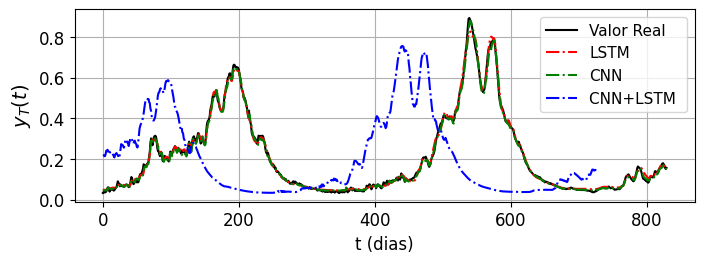

In [ ]:
plt.figure(figsize=(8,2.5))  # Definindo o tamanho da figura
plt.plot(y_teste[500:1330,0], label='Valor Real',color='k')
plt.plot(yp_LSTM[500:1330,0],'-.',label='LSTM', color='red')
plt.plot(yp_CNN1D[500:1330,0], '-.',label='CNN', color='green')
plt.plot(yp_LSTMCNN1D[500:1330,0], '-.',label='CNN+LSTM ', color='blue')

plt.grid()
plt.ylabel('$y_T(t)$',fontsize=14)
plt.xlabel('t (dias)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.savefig(enderecoSimul+'SimulDia1.png', dpi = 300,bbox_inches='tight')
plt.legend(fontsize=11)
plt.show()

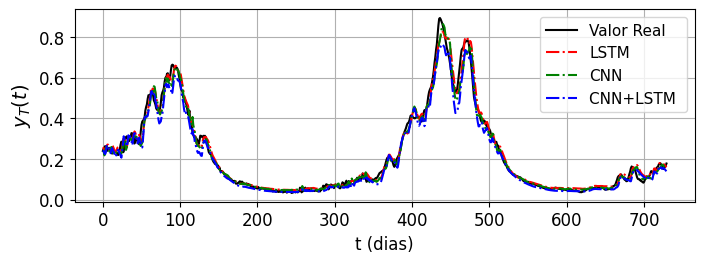

In [ ]:
plt.figure(figsize=(8,2.5)) # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,3], label='Valor Real',color='k')
plt.plot(yp_LSTM[600:1330,3],'-.',label='LSTM', color='red')
plt.plot(yp_CNN1D[600:1330,3], '-.',label='CNN', color='green')
plt.plot(yp_LSTMCNN1D[600:1330,4], '-.',label='CNN+LSTM ', color='blue')

plt.grid()
plt.ylabel('$y_T(t)$',fontsize=14)
plt.xlabel('t (dias)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.savefig(enderecoSimul+'SimulDia4.png', dpi = 300,bbox_inches='tight')
plt.legend(fontsize=11)
plt.show()

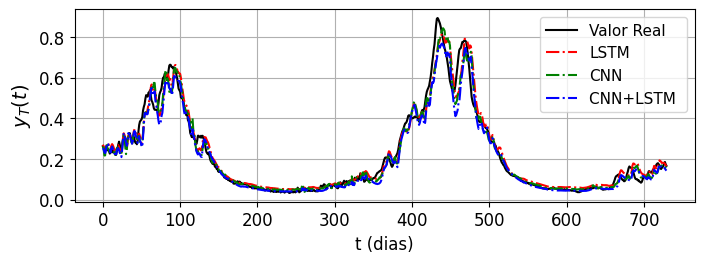

In [ ]:
plt.figure(figsize=(8,2.5))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,6], label='Valor Real',color='k')
plt.plot(yp_LSTM[600:1330,6],'-.',label='LSTM', color='red')
plt.plot(yp_CNN1D[600:1330,6], '-.',label='CNN', color='green')
plt.plot(yp_LSTMCNN1D[600:1330,6], '-.',label='CNN+LSTM ', color='blue')

plt.grid()
plt.ylabel('$y_T(t)$',fontsize=14)
plt.xlabel('t (dias)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.savefig(enderecoSimul+'SimulDia7.png', dpi = 300)
plt.legend(fontsize=11)
plt.show()

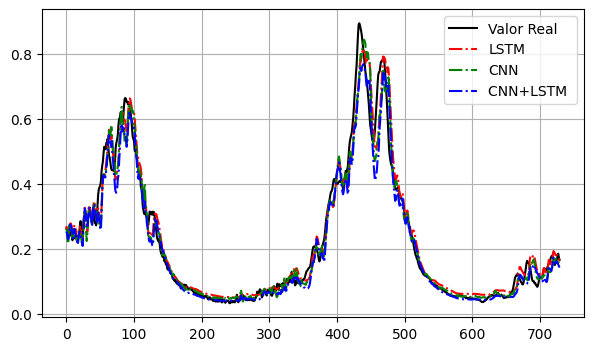

In [ ]:
plt.figure(figsize=(7,4))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,6], label='Valor Real',color='k')
plt.plot(yp_LSTM[600:1330,6],'-.',label='LSTM', color='red')
plt.plot(yp_CNN1D[600:1330,6], '-.',label='CNN', color='green')
plt.plot(yp_LSTMCNN1D[600:1330,6], '-.',label='CNN+LSTM ', color='blue')

plt.grid()
plt.ylabel('$y_T(t)')
#plt.savefig(enderecoSimul+'CNNLSTM1oDia.png', dpi = 300)
plt.legend()
plt.show()

In [ ]:
r2_score(y_teste[:,0],yp_LSTM[:,4])

0.9861200560908993

In [ ]:
def MedidaAjuste(Yreal,Ypred):

  metrica = {'R2':np.zeros(nso),
             'MAE':np.zeros(nso),
             'MSE':np.zeros(nso)}
  MedidaErro = pd.DataFrame(metrica)

  for n in range(nso):
    MedidaErro['R2'][n] = r2_score(Yreal[:, n], Ypred[:, n])
    MedidaErro['MSE'][n] = np.mean(np.power(Yreal[:, n]-Ypred[:, n],2))
    MedidaErro['MAE'][n] = np.mean(np.abs(Yreal[:, n], Ypred[:, n]))


  return MedidaErro

In [ ]:
DadosErroLSTM = MedidaAjuste(y_teste,yp_LSTM)
DadosErroCNN1D = MedidaAjuste(y_teste,yp_CNN1D)
#DadosErroCNN2 = MedidaAjuste(y_teste,yp_CNN2D)
DadosErroLSTMCNN1D = MedidaAjuste(y_teste,yp_LSTMCNN1D)
#DadosErroLSTMCNN2 = MedidaAjuste(y_teste,yp_LSTMCNN2D)

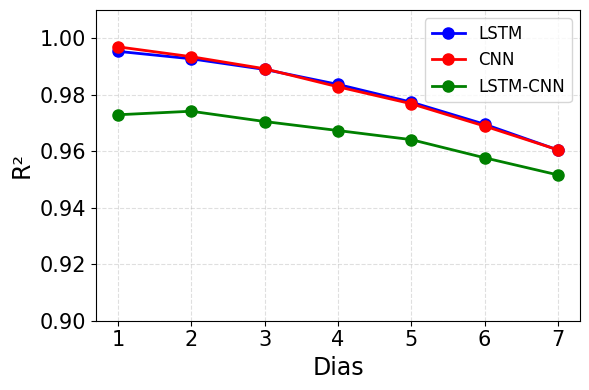

In [ ]:
# Dias
dias = np.arange(1, nso + 1)

# Plotando o gráfico de R² para cada modelo
plt.figure(figsize=(6, 4))

# Plotando os valores de R² para cada modelo
plt.plot(dias, DadosErroLSTM['R2'], label='LSTM', marker='o', color='blue', linewidth=2, markersize=8)
plt.plot(dias, DadosErroCNN1D['R2'], label='CNN', marker='o', color='red', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroCNN2['R2'], label='CNN2D', marker='o', color='red', linewidth=2, markersize=8)
plt.plot(dias, DadosErroLSTMCNN1D['R2'], label='LSTM-CNN', marker='o', color='green', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroLSTMCNN2['R2'], label='LSTM-CNN1D', marker='o', color='black', linewidth=2, markersize=8)

# Definindo rótulos e título
plt.xlabel('Dias', fontsize=17)
plt.ylabel('R²', fontsize=17)

plt.grid(True, linestyle='--', alpha=0.4)

plt.legend(fontsize=12)
plt.ylim(0.9,1.01)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.show()


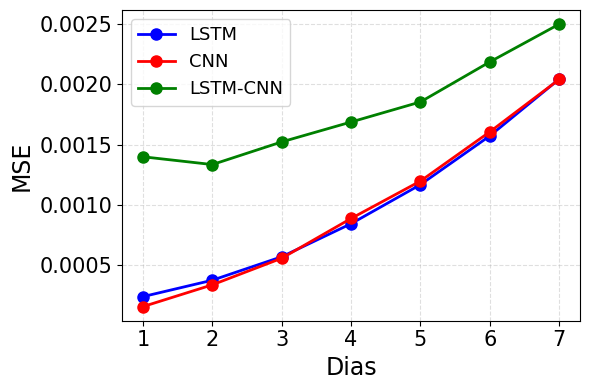

In [ ]:
# Plotando o gráfico de R² para cada modelo
plt.figure(figsize=(6, 4))

# Plotando os valores de R² para cada modelo
plt.plot(dias, DadosErroLSTM['MSE'], label='LSTM', marker='o', color='blue', linewidth=2, markersize=8)
plt.plot(dias, DadosErroCNN1D['MSE'], label='CNN', marker='o', color='red', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroCNN2['MSE'], label='CNN2D', marker='o', color='red', linewidth=2, markersize=8)
plt.plot(dias, DadosErroLSTMCNN1D['MSE'], label='LSTM-CNN', marker='o', color='green', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroLSTMCNN2['MSE'], label='LSTM-CNN1D', marker='o', color='orange', linewidth=2, markersize=8)

# Definindo rótulos e título
plt.xlabel('Dias', fontsize=17)
plt.ylabel('MSE', fontsize=17)

plt.grid(True, linestyle='--', alpha=0.4)

plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.show()



In [ ]:
# Função para imprimir as métricas
def print_metrica(metrica, nome_modelo):
    print(f'Métricas para o modelo {nome_modelo}:')
    for i, dia in enumerate(dias):
        print(f'{dia} - R2: {metrica["R2"][i]:.4f}, MSE: {metrica["MSE"][i]:.4f}')
    print()

# Imprimindo as métricas para cada modelo
print_metrica(DadosErroLSTM, 'LSTM')
print_metrica(DadosErroCNN1D, 'CNN1D')
print_metrica(DadosErroLSTMCNN1D, 'LSTM-CNN1D')

Métricas para o modelo LSTM:
1 - R2: 0.9954, MSE: 0.0002
2 - R2: 0.9927, MSE: 0.0004
3 - R2: 0.9890, MSE: 0.0006
4 - R2: 0.9837, MSE: 0.0008
5 - R2: 0.9774, MSE: 0.0012
6 - R2: 0.9696, MSE: 0.0016
7 - R2: 0.9604, MSE: 0.0020

Métricas para o modelo CNN1D:
1 - R2: 0.9970, MSE: 0.0002
2 - R2: 0.9935, MSE: 0.0003
3 - R2: 0.9892, MSE: 0.0006
4 - R2: 0.9828, MSE: 0.0009
5 - R2: 0.9768, MSE: 0.0012
6 - R2: 0.9689, MSE: 0.0016
7 - R2: 0.9605, MSE: 0.0020

Métricas para o modelo LSTM-CNN1D:
1 - R2: 0.9729, MSE: 0.0014
2 - R2: 0.9742, MSE: 0.0013
3 - R2: 0.9705, MSE: 0.0015
4 - R2: 0.9673, MSE: 0.0017
5 - R2: 0.9641, MSE: 0.0019
6 - R2: 0.9577, MSE: 0.0022
7 - R2: 0.9516, MSE: 0.0025



In [ ]:
# @title
# Modelo LSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(64, activation='relu', input_shape=(nsi, nf)))
modelLSTM.add(Dense(50, activation='relu'))
modelLSTM.add(Dense(nso, activation='linear'))
modelLSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Modelo CONV1D
modelCNN1D = Sequential()
modelCNN1D.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nsi, nf)))
modelCNN1D.add(MaxPooling1D(pool_size=2))
modelCNN1D.add(Flatten())
modelCNN1D.add(Dense(50, activation='relu'))
modelCNN1D.add(Dense(nso, activation='linear'))
modelCNN1D.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Modelo - LSTMConv1D
modelLSTMCNN1D = Sequential()
modelLSTMCNN1D.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nsi, nf)))
modelLSTMCNN1D.add(MaxPooling1D(pool_size=2))
modelLSTMCNN1D.add(LSTM(64, activation='relu'))
modelLSTMCNN1D.add(Dense(50, activation='relu'))
modelLSTMCNN1D.add(Dense(nso, activation='linear'))
modelLSTMCNN1D.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# @title
N_epocas = 1000
N_btsize = 100

In [ ]:
# @title
# Treina LSTM
# restore_best_weights = TRUE

DadosTreinoLSTM = modelLSTM.fit(X_treino, y_treino,
                            epochs = N_epocas,
                            validation_data=(X_teste, y_teste),
                            batch_size=N_btsize,
                            verbose=1)

Epoch 1/1000
67/67 [==============================] - 4s 34ms/step - loss: 0.0242 - val_loss: 0.0048
Epoch 2/1000
67/67 [==============================] - 2s 30ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/1000
67/67 [==============================] - 2s 30ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 4/1000
67/67 [==============================] - 2s 30ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/1000
67/67 [==============================] - 4s 56ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/1000
67/67 [==============================] - 2s 34ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/1000
67/67 [==============================] - 2s 30ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/1000
67/67 [==============================] - 2s 30ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/1000
67/67 [==============================] - 2s 30ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 10/1000
67/67 [==============================] - 2s 30ms/step - loss: 9.7935e-04 - va

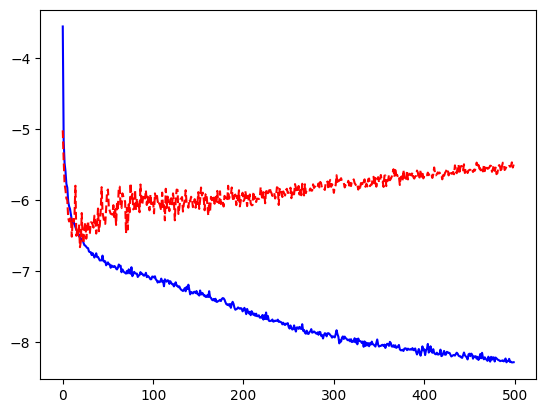

In [ ]:
datatreinoLSTM = {'LSTM_custo_treino'       : DadosTreinoLSTM.history['loss'],
              'LSTM_custo_val'          : DadosTreinoLSTM.history['val_loss']}

# Plotando o logaritmo da perda do modelo LSTM
plt.plot(np.log(datatreinoLSTM['LSTM_custo_treino']), label='LSTM - Treino', color='blue')
# Plotando o logaritmo da perda do modelo LSTM
plt.plot(np.log(datatreinoLSTM['LSTM_custo_val']),'--', label='LSTM - Val', color='red')

Tempo de treinamento 26m19s --- 400 repetições

In [ ]:
# @title
caminhoLSTM = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/ModeloLSTM/'

modelLSTM.save(caminhoLSTM+'modelLSTM.keras')

datatreinoLSTM = {'LSTM_custo_treino'       : DadosTreinoLSTM.history['loss'],
              'LSTM_custo_val'          : DadosTreinoLSTM.history['val_loss']}

DataTreinamentoLSTM =  pd.DataFrame(datatreinoLSTM)
caminhoTreino = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/'
DataTreinamentoLSTM.to_csv(caminhoTreino+'DadosTreinoLSTM.csv')
DataTreinamentoLSTM.head()

import matplotlib.pyplot as plt
import numpy as np

# Criando uma figura
plt.figure(figsize=(7, 4))

# Plotando o logaritmo da perda do modelo LSTM
plt.plot(np.log(DataTreinamentoLSTM['LSTM_custo_treino']), label='LSTM - Treino', color='blue')
# Plotando o logaritmo da perda do modelo LSTM
plt.plot(np.log(DataTreinamentoLSTM['LSTM_custo_val']),'--', label='LSTM - Val', color='red')

# Definindo o limite máximo de épocas para 400
limite_epocas = 125#N_epocas
plt.xlim(0, limite_epocas)

# Adicionando legenda e rótulos

plt.xlabel('Época', fontsize=15)
plt.ylabel('Logaritmo do Custo', fontsize=15)
plt.legend(fontsize=11)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()


In [ ]:
# @title
# Treina CONV1D
DadosTreinoCNN1D = modelCNN1D.fit(X_treino, y_treino,
                                  epochs=N_epocas,
                                  validation_data=(X_teste, y_teste),
                                  batch_size=N_btsize,
                                  verbose=1)

Epoch 1/1000
67/67 [==============================] - 1s 8ms/step - loss: 0.0172 - val_loss: 0.0067
Epoch 2/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 3/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 4/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 8/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 9/1000
67/67 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 10/1000
67/67 [==============================] - 0s 6ms/step - loss: 9.8160e-04 - val_loss: 0.

In [ ]:
# @title
# Treina CONV2D
DadosTreinoCNN2D = modelCNN2D.fit(X_treino, y_treino,
                                  epochs=N_epocas,
                                  batch_size=32, verbose=1,
                                  validation_data=(X_teste, y_teste))


Epoch 1/1000
208/208 [==============================] - 2s 5ms/step - loss: 0.0079 - val_loss: 0.0037
Epoch 2/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 3/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/1000
208/208 [==============================] - 1s 4ms/step - loss: 9.4665e-04 - val_loss: 0.0013
Epoch 8/1000
208/208 [==============================] - 1s 4ms/step - loss: 9.6463e-04 - val_loss: 0.0011
Epoch 9/1000
208/208 [==============================] - 1s 4ms/step - loss: 8.7504e-04 - val_loss: 0.0012
Epoch 10/1000
208/208 [==============================] - 1s 4ms/step -

In [ ]:
# @title
# Treina LSTMCNN1D
DadosTreinoLSTMCNN1D = modelLSTMCNN1D.fit(X_treino, y_treino,
                                          epochs=N_epocas,
                                          batch_size=N_btsize,
                                          verbose=1,
                                          validation_data=(X_teste, y_teste))



Epoch 1/1000
67/67 [==============================] - 3s 27ms/step - loss: 0.0283 - val_loss: 0.0067
Epoch 2/1000
67/67 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 3/1000
67/67 [==============================] - 2s 24ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 4/1000
67/67 [==============================] - 2s 24ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 5/1000
67/67 [==============================] - 3s 41ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 6/1000
67/67 [==============================] - 2s 34ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/1000
67/67 [==============================] - 2s 24ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/1000
67/67 [==============================] - 2s 23ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/1000
67/67 [==============================] - 2s 24ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/1000
67/67 [==============================] - 2s 23ms/step - loss: 9.6041e-04 - va

In [ ]:
# @title
# Treina LSTMCNN2D
DadosTreinoLSTMCNN2D = modelLSTMCNN2D.fit(X_treino, y_treino,
                                          epochs=N_epocas,
                                          batch_size=N_btsize,
                                          verbose=1,
                                          validation_data=(X_teste, y_teste))

Epoch 1/1000
67/67 [==============================] - 38s 474ms/step - loss: 0.0160 - val_loss: 0.0049
Epoch 2/1000
67/67 [==============================] - 13s 197ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 3/1000
67/67 [==============================] - 13s 195ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 4/1000
67/67 [==============================] - 13s 194ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/1000
67/67 [==============================] - 13s 196ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/1000
67/67 [==============================] - 13s 202ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/1000
67/67 [==============================] - 13s 198ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 8/1000
67/67 [==============================] - 13s 196ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/1000
67/67 [==============================] - 14s 211ms/step - loss: 9.2068e-04 - val_loss: 0.0013
Epoch 10/1000
67/67 [==============================] - 14s 206ms/step

# Salvar Modelo

In [ ]:
caminhoLSTM = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/ModeloLSTM/'
caminhoCNN1D = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/ModeloCNN1D/'
caminhoCNN2D = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/ModeloCNN2D/'
caminhoLSTMCNN1D = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/ModeloLSTMCNN1D/'
caminhoLSTMCNN2D = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/ModeloLSTMCNN2D/'


#modelLSTM.save(caminhoLSTM+'modelLSTM.keras')
#modelCNN1D.save(caminhoCNN1D+'modelCNN1D.keras')
#modelCNN2D.save(caminhoCNN2D+'modelCNN2D.keras')
#modelLSTMCNN1D.save(caminhoLSTMCNN1D+'modelLSTMCNN1D.keras')
#modelLSTMCNN2D.save(caminhoLSTMCNN2D+'modelLSTMCNN2D.keras')


In [ ]:
modelo_lstm = load_model(caminhoLSTM + 'modelLSTM.keras')

modelo_cnn1d = load_model(caminhoCNN1D + 'modelCNN1D.keras')

modelo_lstm_cnn1d = load_model(caminhoLSTMCNN1D + 'modelLSTMCNN1D.keras')

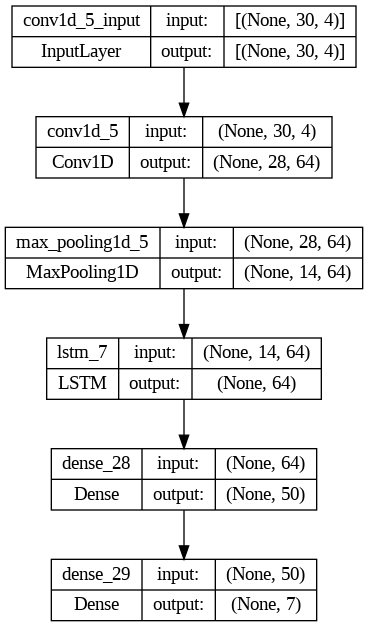

In [ ]:
plot_model(modelo_lstm, to_file='arq_lstm.png', show_shapes=True, show_layer_names=True)
plot_model(modelo_cnn1d, to_file='arq_cnn.png', show_shapes=True, show_layer_names=True)
plot_model(modelo_lstm_cnn1d, to_file='arq_lstm-cnn.png', show_shapes=True, show_layer_names=True)


In [ ]:
dados_treino = '/content/drive/MyDrive/Pesquisa/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/DadosTreino.csv'
dados_treino = pd.read_csv(dados_treino)
dados_treino.head()

,Unnamed: 0,LSTM_custo_treino,LSTM_custo_val,CNN1D_custo_treino,CNN1D_custo_val,CNN2D_custo_treino,CNN2D_custo_val,LSTMCNN1D_custo_treino,LSTMCNN1D_custo_val,LSTMCNN2D_custo_treino,LSTMCNN2D_custo_val
0,0,0.024236,0.004814,0.017183,0.006711,0.007914,0.003689,0.028284,0.006676,0.015971,0.004908
1,1,0.002772,0.003141,0.003526,0.003840,0.002073,0.002301,0.003308,0.003663,0.002501,0.002739
2,2,0.002062,0.002653,0.002150,0.002698,0.001507,0.001710,0.002298,0.003054,0.001810,0.002241
3,3,0.001759,0.002174,0.001570,0.002107,0.001268,0.001536,0.001868,0.002260,0.001307,0.001870
4,4,0.001509,0.001775,0.001338,0.001864,0.001098,0.001293,0.001539,0.001876,0.001244,0.001493


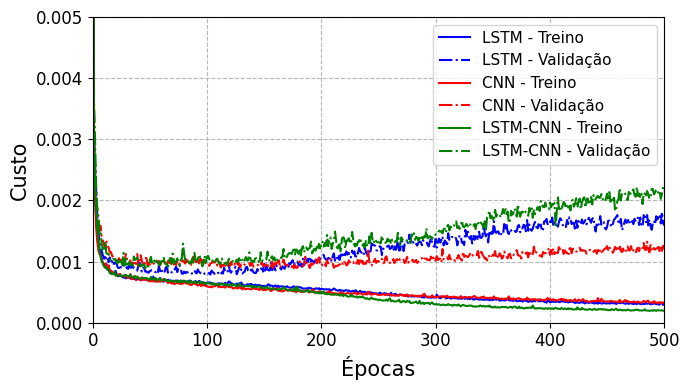

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot((dados_treino['LSTM_custo_treino']), label='LSTM - Treino', color='blue')

plt.plot((dados_treino['LSTM_custo_val']),'-.', label='LSTM - Validação', color='blue')
plt.plot((dados_treino['CNN1D_custo_treino']), label='CNN - Treino', color='red')

plt.plot((dados_treino['CNN1D_custo_val']),'-.', label='CNN - Validação', color='red')


plt.plot((dados_treino['LSTMCNN1D_custo_treino']), label='LSTM-CNN - Treino', color='green')

plt.plot((dados_treino['LSTMCNN1D_custo_val']),'-.', label='LSTM-CNN - Validação', color='green')
# Definindo o limite máximo de épocas para 400
limite_epocas = 500#N_epocas
plt.xlim(0, limite_epocas)
plt.ylim(0, 0.005)

# Adicionando legenda e rótulos

plt.xlabel('Épocas', fontsize=15)
plt.ylabel('Custo', fontsize=15)
plt.legend(fontsize=11)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

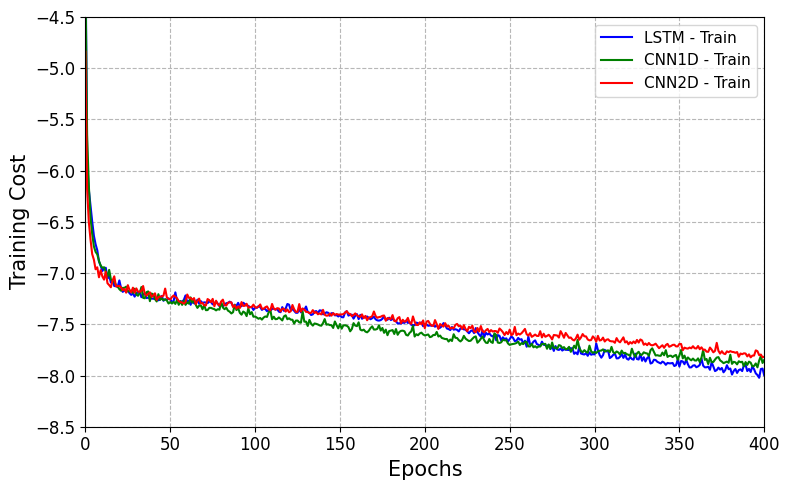

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(np.log((dados_treino['LSTM_custo_treino'])), label='LSTM - Train', color='blue')

#plt.plot((dados_treino['LSTM_custo_val']),'--', label='LSTM - Validation', color='blue')


plt.plot(np.log((dados_treino['CNN1D_custo_treino'])), label='CNN1D - Train', color='green')

#plt.plot((dados_treino['CNN1D_custo_val']),'--', label='CNN - Validation', color='red')


plt.plot(np.log((dados_treino['CNN2D_custo_treino'])), label='CNN2D - Train', color='red')

#plt.plot((dados_treino['LSTMCNN1D_custo_val']),'--', label='LSTM-CNN - Validation', color='green')
# Definindo o limite máximo de épocas para 400
limite_epocas = 400#N_epocas
plt.xlim(0, limite_epocas)

# Adicionando legenda e rótulos
plt.ylim(-8.5, -4.5)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Training Cost', fontsize=15)
plt.legend(fontsize=11)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

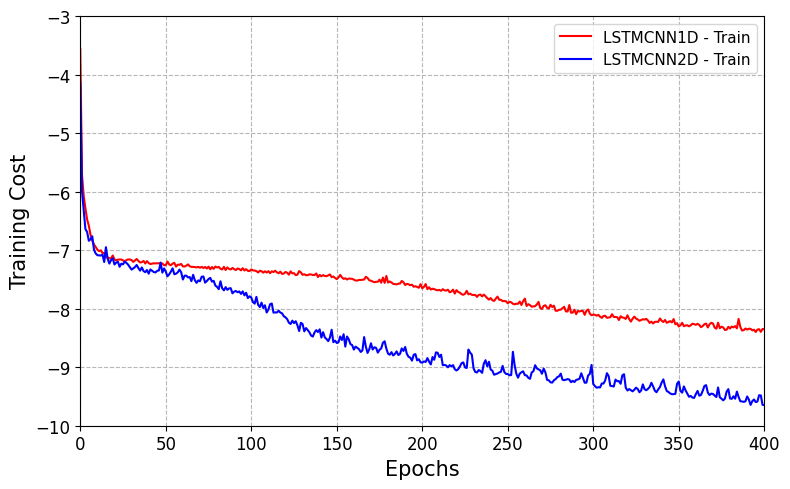

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(np.log((dados_treino['LSTMCNN1D_custo_treino'])), label='LSTMCNN1D - Train', color='red')

#plt.plot((dados_treino['LSTM_custo_val']),'--', label='LSTM - Validation', color='blue')


plt.plot(np.log((dados_treino['LSTMCNN2D_custo_treino'])), label='LSTMCNN2D - Train', color='blue')

#plt.plot((dados_treino['CNN1D_custo_val']),'--', label='CNN - Validation', color='red')


#plt.plot(np.log((dados_treino['CNN2D_custo_treino'])), label='CNN2D - Train', color='red')

#plt.plot((dados_treino['LSTMCNN1D_custo_val']),'--', label='LSTM-CNN - Validation', color='green')
# Definindo o limite máximo de épocas para 400
limite_epocas = 400#N_epocas
plt.xlim(0, limite_epocas)
plt.ylim(-10,-3)
# Adicionando legenda e rótulos
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Training Cost', fontsize=15)
plt.legend(fontsize=11)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

In [ ]:
#datatreino = {'LSTM_custo_treino'       : DadosTreinoLSTM.history['loss'],
#              'LSTM_custo_val'          : DadosTreinoLSTM.history['val_loss'],
#              'CNN1D_custo_treino'      : DadosTreinoCNN1D.history['loss'],
#              'CNN1D_custo_val'         : DadosTreinoCNN1D.history['val_loss'],
#              'LSTMCNN1D_custo_treino'  : DadosTreinoLSTMCNN1D.history['loss'],
#              'LSTMCNN1D_custo_val'     : DadosTreinoLSTMCNN1D.history['val_loss'],
#              }
#
#DataTreinamento =  pd.DataFrame(datatreino)
#caminhoTreino = '/content/drive/MyDrive/CBA2024-LSTM-VazãoAfluente/ResultadosArtigoCBA/'
#DataTreinamento.to_csv(caminhoTreino+'DadosTreino.csv')
#DataTreinamento.head()


- 1 - Carregar dados e modelos (LSTM, CNN, LSTMpCNN);
- 2 - Dados de custo de treino e validação - Figura comparando os três modelos;
- Todos os dados de validação - apenas uma janela:
- 3 - Simular os modelos: Curva para melhor modelo e melhor dia;
- 3 - Simular os modelos: Curva para melhor modelo e pior dia;
- 3 - Simular os modelos: Curva para pior modelo e melhor dia;
- 3 - Simular os modelos: Curva para pior modelo e pior dia;
- Refazer as tabelas;
- Refazer gráficos do custo para os três modelos;
- Apresentar a estrutura dos modelos;

- Template do BRACIS - ENIAC - Passar conteúdo do CBA para o BRACIS;
- Estruturar, revisar e redigir a sessção de fundamentos;


# 10) Gráficos de perda

Observando esses gráficos de perda, é possível identificar o progresso do treinamento, verificar se a perda está diminuindo consistentemente e fazer ajustes adequados no modelo ou no processo de treinamento, se necessário. Além disso, eles fornecem informações úteis para avaliar a convergência e a estabilidade do treinamento.

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np

# Plotando o logaritmo da perda
plt.figure(figsize=(5,10))
plt.subplot(511)
plt.plot((DataTreinamento['LSTM_custo_treino']), color='r', linewidth=2, label = 'Custo Treinamento')
plt.plot((DataTreinamento['LSTM_custo_val']), color='g', linewidth=2)
plt.subplot(512)
plt.plot((DataTreinamento['CNN1D_custo_treino']), color='r', linewidth=2, label = 'Custo Treinamento')
plt.plot((DataTreinamento['CNN1D_custo_val']), color='g', linewidth=2)
plt.subplot(513)
plt.plot((DataTreinamento['CNN2D_custo_treino']), color='r', linewidth=2, label = 'Custo Treinamento')
plt.plot((DataTreinamento['CNN2D_custo_val']), color='g', linewidth=2)
plt.subplot(514)
plt.plot((DataTreinamento['LSTMCNN1D_custo_treino']), color='r', linewidth=2, label = 'Custo Treinamento')
plt.plot((DataTreinamento['LSTMCNN1D_custo_val']), color='g', linewidth=2)
plt.subplot(515)
plt.plot((DataTreinamento['LSTMCNN1D_custo_treino']), color='r', linewidth=2, label = 'Custo Treinamento')
plt.plot((DataTreinamento['LSTMCNN1D_custo_val']), color='g', linewidth=2)

plt.show()


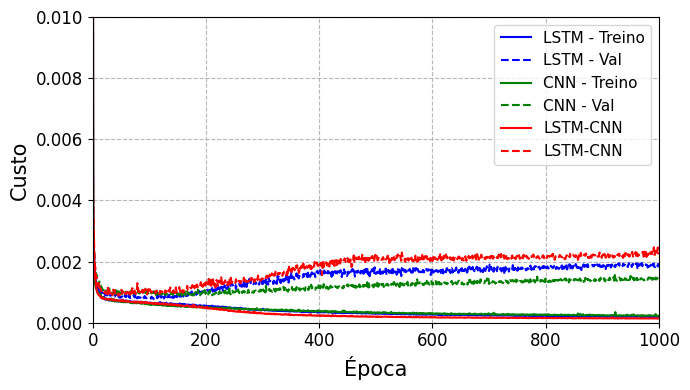

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np

# Criando uma figura
plt.figure(figsize=(7, 4))

# Plotando o logaritmo da perda do modelo LSTM
plt.plot((DataTreinamento['LSTM_custo_treino']), label='LSTM - Treino', color='blue')
# Plotando o logaritmo da perda do modelo LSTM
plt.plot((DataTreinamento['LSTM_custo_val']),'--', label='LSTM - Val', color='blue')

# Plotando o logaritmo da perda do modelo CNN1D
plt.plot((DataTreinamento['CNN1D_custo_treino']), label='CNN - Treino', color='green')
plt.plot((DataTreinamento['CNN1D_custo_val']),'--', label='CNN - Val', color='green')

# Plotando o logaritmo da perda do modelo CNN2D
plt.plot((DataTreinamento['LSTMCNN1D_custo_treino']), label='LSTM-CNN', color='red')
plt.plot((DataTreinamento['LSTMCNN1D_custo_val']),'--', label='LSTM-CNN', color='red')


# Definindo o limite máximo de épocas para 400
limite_epocas = N_epocas
plt.xlim(0, limite_epocas)
plt.ylim(0,0.01)
# Adicioplt.xlim(0, limite_epocas)nando legenda e rótulos

plt.xlabel('Época', fontsize=15)
plt.ylabel('Custo', fontsize=15)
plt.legend(fontsize=11)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()


y_teste.shape

In [ ]:
y_teste

In [ ]:
yp_LSTM = modelo_lstm.predict(X_teste)
yp_CNN1D = modelo_cnn1d.predict(X_teste)
#yp_CNN2D = modeloCNN2D.predict(X_teste)
yp_LSTMCNN1D = modelo_lstm_cnn1d.predict(X_teste)
#yp_LSTMCNN2D = modelLSTMCNN2D.predict(X_teste)

69/69 [==============================] - 0s 4ms/step


(2195, 7)

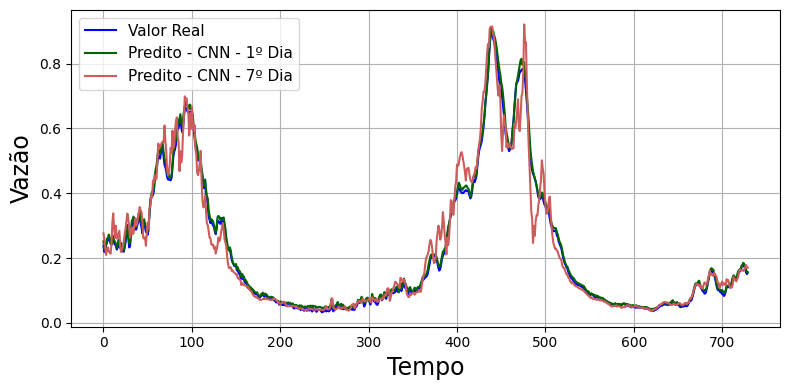

In [ ]:
# Realizando previsões

plt.figure(figsize=(8,4))  # Definindo o tamanho da figura
plt.plot(y_teste[600:1330,0], label='Valor Real',color='blue')
#plt.plot(yp_LSTM[480:600,0], label='Predito - LSTM')
plt.plot(yp_CNN1D[600:1330,0], label='Predito - CNN - 1º Dia', color='darkgreen')
plt.plot(yp_CNN1D[600:1330,6], label='Predito - CNN - 7º Dia',color='indianred')
#plt.plot(yp_CNN2D[480:600,0], label='Predito - CNN2D')
#plt.plot(yp_LSTMCNN1D[600:1330,0], label='Predito - LSTM-CNN - 1º Dia', color='darkgreen')
#plt.plot(yp_LSTMCNN1D[600:1330,6], label='Predito - LSTM-CNN - 7º Dia',color='indianred')
#plt.plot(yp_LSTMCNN2D[480:600,6], label='Predito - LSTMCNN2D')



plt.xlabel('Tempo',fontsize=17)
plt.ylabel('Vazão',fontsize=17)
plt.grid()
plt.legend(loc='upper left',fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
from graphviz import Digraph
from IPython.display import Image
from google.colab import files

# Criando o objeto Digraph com configurações de estilo
dot = Digraph(comment='Improved Flowchart for Prediction Process')

# Definindo estilos para os nós
styles = {
    'graph': {
        'fontsize': '16',
        'bgcolor': '#f0f0f0'
    },
    'nodes': {
        'shape': 'box',
        'style': 'filled',
        'fillcolor': '#e8e8e8',
        'fontname': 'Helvetica',
        'fontsize': '12',
        'fontcolor': '#333333',
        'color': '#000000',
        'penwidth': '1.5'
    },
    'edges': {
        'style': 'solid',
        'color': 'black',
        'arrowhead': 'open',
        'fontname': 'Helvetica',
        'fontsize': '12',
        'fontcolor': '#333333',
        'penwidth': '1.5'
    }
}

def apply_styles(graph, styles):
    graph.graph_attr.update(styles['graph'])
    graph.node_attr.update(styles['nodes'])
    graph.edge_attr.update(styles['edges'])
    return graph

# Adicionando nós com descrições detalhadas
dot.node('A', 'Start\nInitialize the process', shape='ellipse', fillcolor='#a3c1da')
dot.node('B', 'Load Data\nLoad the dataset from source', fillcolor='#add8e6')
dot.node('C', 'Split Data\nDivide data into training and testing sets', fillcolor='#add8e6')
dot.node('D', 'Train Models\nTrain LSTM, CNN, and LSTM-CNN models', fillcolor='#add8e6')
dot.node('E1', 'Train LSTM\nTrain Long Short-Term Memory model', fillcolor='#b0e57c')
dot.node('E2', 'Train CNN\nTrain Convolutional Neural Network model', fillcolor='#b0e57c')
dot.node('E3', 'Train LSTM-CNN\nTrain combined LSTM and CNN model', fillcolor='#b0e57c')
dot.node('F', 'Make Predictions\nUse trained models to make predictions', fillcolor='#add8e6')
dot.node('G', 'Evaluate Predictions\nAssess the accuracy and performance of the models', fillcolor='#add8e6')
dot.node('H', 'Plot Results\nGenerate visual plots for analysis', fillcolor='#add8e6')
dot.node('I', 'End\nComplete the process', shape='ellipse', fillcolor='#a3c1da')

# Adicionando arestas com descrições
dot.edge('A', 'B', label='Start the process')
dot.edge('B', 'C', label='Data is loaded')
dot.edge('C', 'D', label='Data is split')
dot.edge('D', 'E1', label='Train LSTM Model')
dot.edge('D', 'E2', label='Train CNN Model')
dot.edge('D', 'E3', label='Train LSTM-CNN Model')
dot.edge('E1', 'F', label='LSTM Model trained')
dot.edge('E2', 'F', label='CNN Model trained')
dot.edge('E3', 'F', label='LSTM-CNN Model trained')
dot.edge('F', 'G', label='Predictions made')
dot.edge('G', 'H', label='Evaluate predictions')
dot.edge('H', 'I', label='Plot the results')

# Aplicando estilos
dot = apply_styles(dot, styles)

# Renderizando o fluxograma
output_path = '/content/improved_flowchart_prediction_process'
dot.render(output_path, format='png')

# Exibir a imagem gerada
Image(filename=output_path + '.png')

# Baixar o arquivo gerado
files.download(output_path + '.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

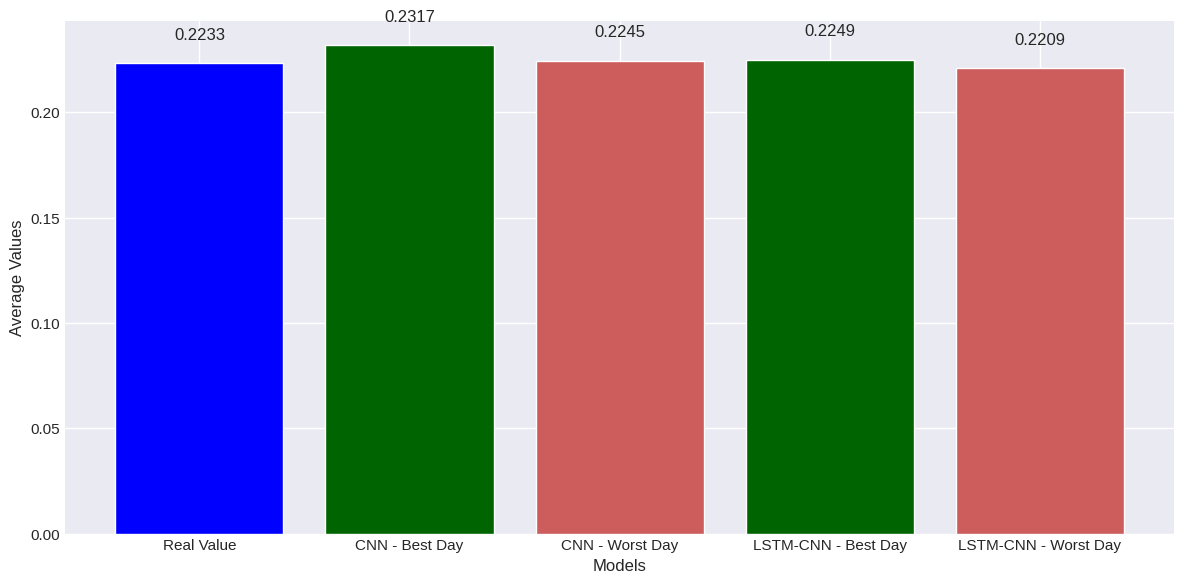

In [ ]:
start, end = 600, 1330
real_mean = y_teste[start:end, 0].mean()
cnn_best_mean = yp_CNN1D[start:end, 0].mean()
cnn_worst_mean = yp_CNN1D[start:end, 6].mean()
lstmc_cnn_best_mean = yp_LSTMCNN1D[start:end, 0].mean()
lstmc_cnn_worst_mean = yp_LSTMCNN1D[start:end, 6].mean()

# Dados para o gráfico de barras
labels = ['Real Value', 'CNN - Best Day', 'CNN - Worst Day', 'LSTM-CNN - Best Day', 'LSTM-CNN - Worst Day']
means = [real_mean, cnn_best_mean, cnn_worst_mean, lstmc_cnn_best_mean, lstmc_cnn_worst_mean]

# Criar gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, means, color=['blue', 'darkgreen', 'indianred', 'darkgreen', 'indianred'])

# Adicionar título e rótulos

plt.xlabel('Models')
plt.ylabel('Average Values')

# Adicionar valores nas barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

# Melhorar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

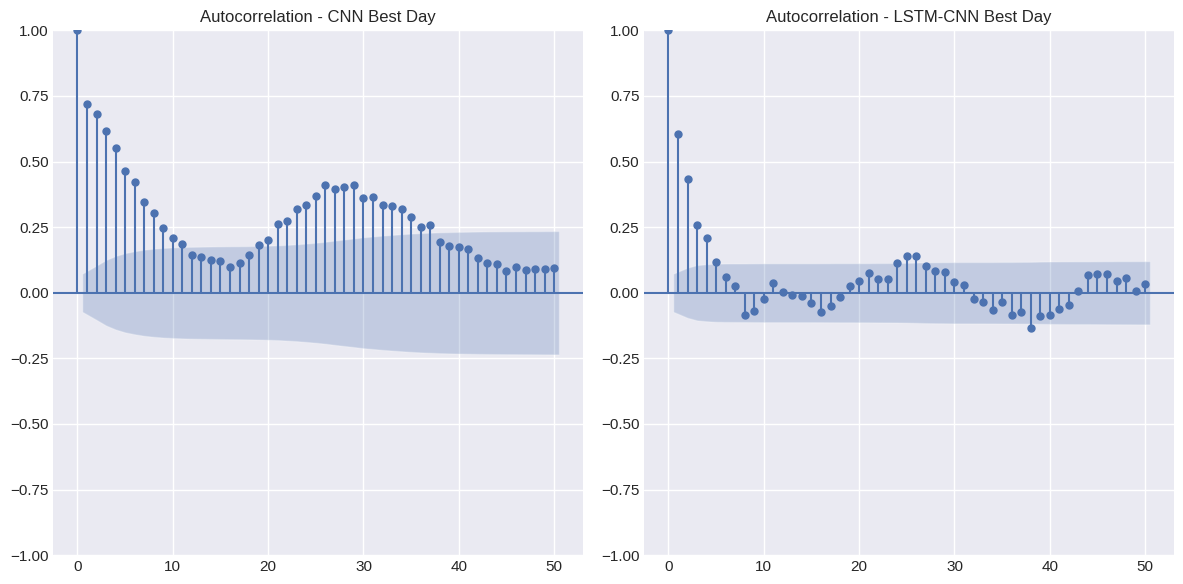

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
errors_cnn_best = y_teste[start:end, 0] - yp_CNN1D[start:end, 0]
errors_lstm_cnn_best = y_teste[start:end, 0] - yp_LSTMCNN1D[start:end, 0]

# Criar gráficos de autocorrelação
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(errors_cnn_best, lags=50, ax=plt.gca(), title='Autocorrelation - CNN Best Day')

plt.subplot(122)
plot_acf(errors_lstm_cnn_best, lags=50, ax=plt.gca(), title='Autocorrelation - LSTM-CNN Best Day')

plt.tight_layout()
plt.show()

In [ ]:
r2_score(y_teste[:,0],yp_LSTM[:,4])

0.9674220346459177

In [ ]:
def MedidaAjuste(Yreal,Ypred):

  metrica = {'R2':np.zeros(nso),
             'MAE':np.zeros(nso),
             'MSE':np.zeros(nso)}
  MedidaErro = pd.DataFrame(metrica)

  for n in range(nso):
    MedidaErro['R2'][n] = r2_score(Yreal[:, n], Ypred[:, n])
    MedidaErro['MSE'][n] = np.mean(np.power(Yreal[:, n]-Ypred[:, n],2))
    MedidaErro['MAE'][n] = np.mean(np.abs(Yreal[:, n], Ypred[:, n]))


  return MedidaErro

In [ ]:
DadosErroLSTM = MedidaAjuste(y_teste,yp_LSTM)
DadosErroCNN1 = MedidaAjuste(y_teste,yp_CNN1D)
#DadosErroCNN2 = MedidaAjuste(y_teste,yp_CNN2D)
DadosErroLSTMCNN1 = MedidaAjuste(y_teste,yp_LSTMCNN1D)
#DadosErroLSTMCNN2 = MedidaAjuste(y_teste,yp_LSTMCNN2D)

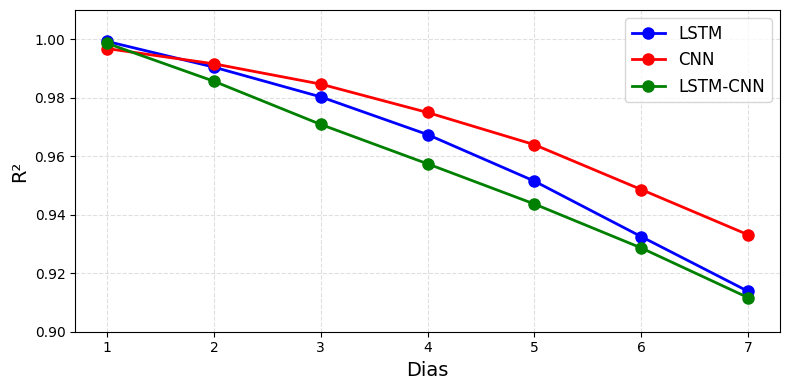

In [ ]:

# Dias
dias = np.arange(1, nso + 1)

# Plotando o gráfico de R² para cada modelo
plt.figure(figsize=(8, 4))

# Plotando os valores de R² para cada modelo
plt.plot(dias, DadosErroLSTM['R2'], label='LSTM', marker='o', color='blue', linewidth=2, markersize=8)
plt.plot(dias, DadosErroCNN1['R2'], label='CNN', marker='o', color='red', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroCNN2['R2'], label='CNN2D', marker='o', color='red', linewidth=2, markersize=8)
plt.plot(dias, DadosErroLSTMCNN1['R2'], label='LSTM-CNN', marker='o', color='green', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroLSTMCNN2['R2'], label='LSTM-CNN1D', marker='o', color='black', linewidth=2, markersize=8)

# Definindo rótulos e título
plt.xlabel('Dias', fontsize=14)
plt.ylabel('R²', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)

plt.legend(fontsize=12)
plt.ylim(0.9,1.01)

plt.tight_layout()
plt.show()


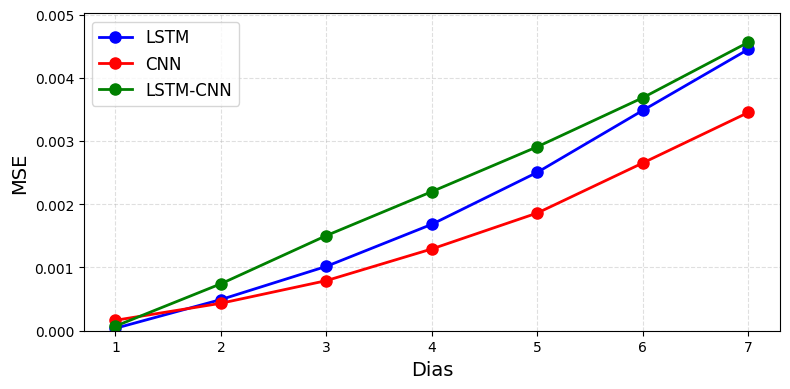

In [ ]:
# Plotando o gráfico de R² para cada modelo
plt.figure(figsize=(8, 4))

# Plotando os valores de R² para cada modelo
plt.plot(dias, DadosErroLSTM['MSE'], label='LSTM', marker='o', color='blue', linewidth=2, markersize=8)
plt.plot(dias, DadosErroCNN1['MSE'], label='CNN', marker='o', color='red', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroCNN2['MSE'], label='CNN2D', marker='o', color='red', linewidth=2, markersize=8)
plt.plot(dias, DadosErroLSTMCNN1['MSE'], label='LSTM-CNN', marker='o', color='green', linewidth=2, markersize=8)
#plt.plot(dias, DadosErroLSTMCNN2['MSE'], label='LSTM-CNN1D', marker='o', color='orange', linewidth=2, markersize=8)

# Definindo rótulos e título
plt.xlabel('Dias', fontsize=14)
plt.ylabel('MSE', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)

plt.legend(fontsize=12)
plt.ylim(0.0, max(max(DadosErroLSTM['MSE']), max(DadosErroCNN1['MSE']), max(DadosErroLSTMCNN1['MSE'])) * 1.1)
plt.tight_layout()
plt.show()



# 11) Validação

1) Preparação dos dados de validação:

- yvv = y[tv + 1].reshape(Nv, 1): Obtém as sequências temporais de saída do reservatório Tucuruí para o conjunto de validação.
- yv = yv.reshape(Nv, 1): Redimensiona as sequências temporais de entrada do reservatório Tucuruí para o formato adequado.
- xv = xv.reshape(Nv, 1): Redimensiona as sequências temporais de entrada do reservatório Estreito para o formato adequado.
- zv = zv.reshape(Nv, 1): Redimensiona as sequências temporais de entrada do reservatório Lajeado para o formato adequado.

2) Criação do conjunto de validação:

- dataset_val = np.hstack((xv, yv, zv, yvv)): Cria um conjunto de validação combinando as sequências temporais de entrada e saída dos reservatórios Tucuruí, Estreito e Lajeado.
- X_teste, y_teste = split_sequences(dataset_val, nsi, nso): Utiliza a função split_sequences para dividir o conjunto de validação em amostras com um determinado número de passos anteriores (nsi) e um número de passos futuros (nso) para cada amostra. Isso cria os conjuntos de entrada (X_teste) e saída (y_teste) para o teste do modelo.

- Gráfico com subgráficos separados para cada dia futuro, mostrando as previsões do modelo (linha vermelha) e os valores reais correspondentes (linha azul). Isso permite visualizar e comparar a performance do modelo em relação aos dados reais.

In [ ]:
# Função para imprimir as métricas
def print_metrica(metrica, nome_modelo):
    print(f'Métricas para o modelo {nome_modelo}:')
    for i, dia in enumerate(dias):
        print(f'{dia} - R2: {metrica["R2"][i]:.4f}, MSE: {metrica["MSE"][i]:.4f}')
    print()

# Imprimindo as métricas para cada modelo
print_metrica(DadosErroLSTM, 'LSTM')
print_metrica(DadosErroCNN1, 'CNN1D')
print_metrica(DadosErroLSTMCNN1, 'LSTM-CNN1D')

Métricas para o modelo LSTM:
1 - R2: 0.9993, MSE: 0.0000
2 - R2: 0.9905, MSE: 0.0005
3 - R2: 0.9803, MSE: 0.0010
4 - R2: 0.9674, MSE: 0.0017
5 - R2: 0.9515, MSE: 0.0025
6 - R2: 0.9325, MSE: 0.0035
7 - R2: 0.9138, MSE: 0.0045

Métricas para o modelo CNN1D:
1 - R2: 0.9968, MSE: 0.0002
2 - R2: 0.9916, MSE: 0.0004
3 - R2: 0.9847, MSE: 0.0008
4 - R2: 0.9750, MSE: 0.0013
5 - R2: 0.9640, MSE: 0.0019
6 - R2: 0.9486, MSE: 0.0027
7 - R2: 0.9332, MSE: 0.0035

Métricas para o modelo LSTM-CNN1D:
1 - R2: 0.9986, MSE: 0.0001
2 - R2: 0.9856, MSE: 0.0007
3 - R2: 0.9709, MSE: 0.0015
4 - R2: 0.9574, MSE: 0.0022
5 - R2: 0.9437, MSE: 0.0029
6 - R2: 0.9287, MSE: 0.0037
7 - R2: 0.9117, MSE: 0.0046



In [ ]:
# @title
# Plotando as previsões e os valores reais
plt.figure(figsize=(12, 20))
for n in range(nso):
    ax = plt.subplot(nso, 1, n + 1)
    plt.plot(y_teste[:, n], label='Valor Real')
    plt.plot(yp_LSTM[:, n], label='Previsão')
    plt.xlabel('Tempo')
    plt.ylabel('Vazão')
    plt.title(f'Dia {n+1}')
    plt.grid()
    if n == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1),fontsize='large')
    else:
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.5),fontsize='large')

plt.tight_layout()
plt.show()